# Adaptive sampling

This notebook introduces the adaptive sampling capabilities within `sumomo`. The underlying black box function is the peaks function (below) with a feasibility constraint enforcing samples outside of a circle centered at the origin with a radius of 2 to be infeasible.

$$ \hat{f}(\textbf{x}) = 3(1-x_0)^2 \exp\left(-x_0^2 - (x_1 + 1)^2\right) - 10 \left(\frac{x_0}{5} - x_0^3 - x_1^5\right)\exp\left(-x_0^2 - x_1^2\right) - \frac{1}{3}\exp\left(-(x_0+1)^2 - x_1^2\right) $$

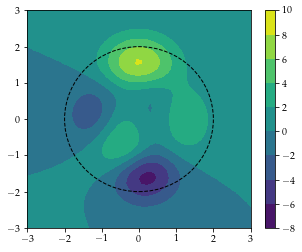

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from utils import plot_underlying


plot_underlying()

## Maximise GPR standard deviation with GPC constraints

Begin by fitting a Gaussian process regression and classification surrogate using relatively few samples.

In [2]:
from sumomo import DataHandler
from utils import BlackBox
from sumomo import GPR, GPC


n = 25
space = [[-3.0, 3.0],[-3.0, 3.0]]

dh = DataHandler()
dh.init(n, space, method='lhs')

bb = BlackBox()
dh.y = bb.sample_y(dh.x)
dh.t = bb.sample_t(dh.x)

dh.scale()

gpr = GPR()
gpr.fit(dh.x_, dh.y_)

gpc = GPC()
gpc.fit(dh.x_, dh.t)

Plot the Gaussian process regression predictions and standard deviation with the classifier binary separator.

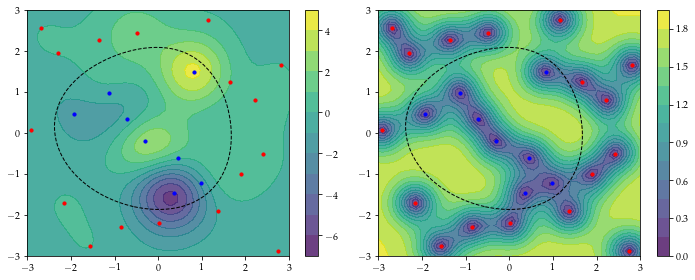

In [3]:
from utils import plot_gpr_gpc


plot_gpr_gpc(space, dh, gpr, gpc)

`sumomo` provides the `AdaptiveSampler` object to enable users to build and solve `pyomo` formulations for adaptive sampling. The method `max_constrained_gp_std()` maximises the Gaussian process regression standard deviation (or more specifically, minimise $k^\intercal K^{-1} k$) subject to classification model constraints.

In [4]:
from sumomo import AdaptiveSampler


ads = AdaptiveSampler(dh.space_, gpr, gpc)
mod = ads.max_constrained_gp_std()

Setup a `pyomo` solver and solve the adaptive sampling optimisation formulation.

In [5]:
import pyomo.environ as pyo


solver = pyo.SolverFactory('baron')
res = solver.solve(mod, tee=True)

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value -.143545815874E-001
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1             0.55    -0.143536E-01     2.11415    
       29

Retrieve the solution and plot.

[[-1.38311062 -0.79101754]]


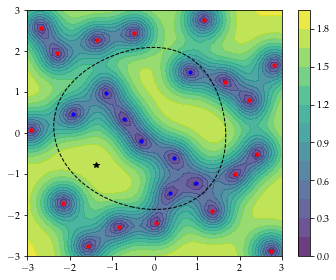

In [6]:
import numpy as np
from utils import plot_adaptive_gp


x = np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1)
x = dh.inv_scale_x(x)
print(x)

plot_adaptive_gp(space, dh, gpr, gpc, x.ravel())

Sample the black box at the new sample point, append to the existing data in the `DataHandler` instance, scale, fit regression and classification models on the new data and plot.

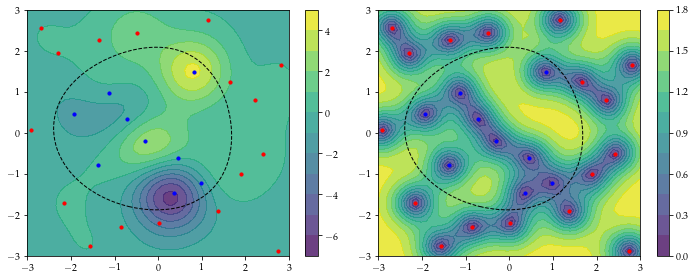

In [7]:
y = bb.sample_y(x)
t = bb.sample_t(x)

dh.x = np.r_[ dh.x, x ]
dh.y = np.r_[ dh.y, y ]
dh.t = np.r_[ dh.t, t ]
dh.scale()

gpr = GPR()
gpr.fit(dh.x_, dh.y_)
gpc = GPC()
gpc.fit(dh.x_, dh.t)

plot_gpr_gpc(space, dh, gpr, gpc)

One complete iteration formulates the adaptive sampling `pyomo` formulation, solves it, inverse scales the solution to the original space, samples from the black box, appends to the existing data, standardises the data, and fits the surrogate models on the new data.

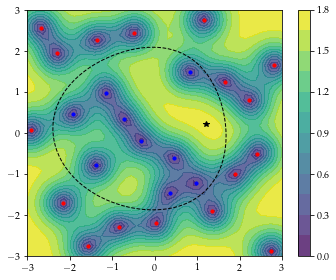

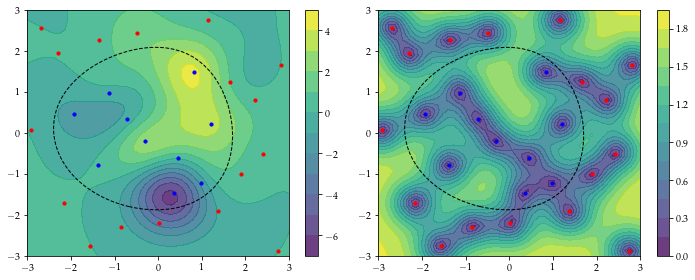

In [8]:
ads = AdaptiveSampler(dh.space_, gpr, gpc)
mod = ads.max_constrained_gp_std()
res = solver.solve(mod, tee=False)
x = np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1)
x = dh.inv_scale_x(x)

plot_adaptive_gp(space, dh, gpr, gpc, x.ravel())

y = bb.sample_y(x)
t = bb.sample_t(x)

dh.x = np.r_[ dh.x, x ]
dh.y = np.r_[ dh.y, y ]
dh.t = np.r_[ dh.t, t ]
dh.scale()

gpr = GPR()
gpr.fit(dh.x_, dh.y_)
gpc = GPC()
gpc.fit(dh.x_, dh.t)

plot_gpr_gpc(space, dh, gpr, gpc)

## Maximise Delaunay triangle size with classification constraints

`sumomo` provides a **heuristic-based** approach to adaptive sampling by using Delaunay triangulation to partition to sample space and add a new sample at the centroid of the largest region. This approach is formulated as a MILP problem which can be quickly solved to provide relatively quick adaptive samples. Such a heuristic-based approach can also be used with any underlying surrogate model as only the input data is required to perform the Delaunay triangulation.

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             0.11     0.451121         0.468748    
          1             0             0.12     0.451121         0.451122    



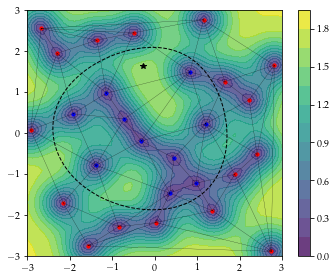

In [9]:
from utils import plot_adaptive_triangles


ads = AdaptiveSampler(dh.space_, gpr, gpc)
mod = ads.max_constrained_triangle(dh.x_)
res = solver.solve(mod, tee=True)

x = np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1)
x = dh.inv_scale_x(x)

plot_adaptive_triangles(space, dh, gpr, gpc, x.ravel(), ads)